# Tensorflow - Help Protect the Great Barrier Reef

본 대회는 산호초의 수중 영상을 학습한 object detection model을 구축하여 실시간으로 불가사리를 정확하게 탐지하는 대회이다.<br>
평가지표는 IoU (range of 0.3 to 0.8 with a step size of 0.05) 를 기준으로 한 F2-Score를 사용한다.<br>
최종 F2 점수는 각 IoU 임계값에서 F2 점수의 평균으로 계산<br>
<br>
<br>
$$F2 = 5*{precision*recall \over 4*precision+recall}$$

## Import

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [11]:
import sys
# sys.path.append('./ffmpeg-python')
import cv2
import ast
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ffmpeg
import subprocess
from IPython.display import Video
from tqdm import tqdm
import tensorflow as tf
#import tensorflow_addons as tfa
import logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings('ignore')

# plt.style.use('ggplot')
cm = sns.light_palette("blue", as_cmap=True)
pd.option_context('display.max_colwidth', 100)

## Dataframe eda

- 데이터 정보들은 다음과 같다<br>
    * 학습 이미지개수 : 23,501 장 (video0 / video1 / video2)
    * CSV 고유 데이터 개수 : 23,501 장 (중복값 없음)
    
* `train_images/` - Folder containing training set photos of the form `video_{video_id}/{video_frame}.jpg`.

* `[train/test].csv` - Metadata for the images. As with other test files, most of the test metadata data is only available to your notebook upon submission. Just the first few rows available for download.

* `video_id` - ID number of the video the image was part of. The video ids are not meaningfully ordered.
* `video_frame` - The frame number of the image within the video. Expect to see occasional gaps in the frame number from when the diver surfaced.
* `sequence` - ID of a gap-free subset of a given video. The sequence ids are not meaningfully ordered.
* `sequence_frame` - The frame number within a given sequence.
* `image_id` - ID code for the image, in the format `{video_id}-{video_frame}`
* `annotations` - The bounding boxes of any starfish detections in a string format that can be evaluated directly with Python. Does not use the same format as the predictions you will submit. Not available in test.csv. A bounding box is described by the pixel coordinate `(x_min, y_min)` of its lower left corner within the image together with its `width` and `height` in pixels --> (COCO format).

아래 train csv를 보면 annotations(detection좌표)값이 없는 데이터들이 있다.

그렇다면 좌표값이 존재하는 데이터는 얼마나 될까?

In [12]:
df = pd.read_csv('./data/train.csv')
train_dir = "./data/train_images"
df['image_path'] = train_dir + "/video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"
print(f'데이터프레임 길이 : {len(df)}')
df.head().style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

데이터프레임 길이 : 23501


,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,0,40258,0,0,0-0,[],./data/train_images/video_0/0.jpg
1,0,40258,1,1,0-1,[],./data/train_images/video_0/1.jpg
2,0,40258,2,2,0-2,[],./data/train_images/video_0/2.jpg
3,0,40258,3,3,0-3,[],./data/train_images/video_0/3.jpg
4,0,40258,4,4,0-4,[],./data/train_images/video_0/4.jpg


In [13]:
a = len(os.listdir('./data/train_images/video_0')) + len(os.listdir('./data/train_images/video_1')) + len(os.listdir('./data/train_images/video_2'))
print(f'이미지개수 : {a}')

이미지개수 : 23501


In [14]:
for video_id in df['video_id'].unique():
    print(f'video_id: {video_id}')
    print(f'w   annotations:  {sum(df[df["video_id"]==video_id]["annotations"] == "[]")}')
    print(f'w/o annotations:  {sum(df[df["video_id"]==video_id]["annotations"] != "[]")}\n')

video_id: 0
w   annotations:  4565
w/o annotations:  2143

video_id: 1
w   annotations:  6133
w/o annotations:  2099

video_id: 2
w   annotations:  7884
w/o annotations:  677



<br>
<br>
<br>
<br>
약 4919개의 비디오 씬들이 좌표값을 가지고 있는 것을 볼 수 있다.
<br>
그렇다면 좌표값이 없는 데이터들은 버려야하는 것일까?
<br>
아마 좌표값이 없는 이유는 영상데이터이기 때문이다. 왜냐하면 모든 영상 프레임에서 불가사리가 감지되는것은 아니니까..! 

In [15]:
print(f'좌표값이 존재하는 데이터들 : {len(df[df.annotations.str.len() > 2])} 개')
df[df.annotations.str.len() > 2].head(5).style.background_gradient(cmap=cm) # filling up the annotation column

좌표값이 존재하는 데이터들 : 4919 개


,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",./data/train_images/video_0/16.jpg
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",./data/train_images/video_0/17.jpg
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",./data/train_images/video_0/18.jpg
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",./data/train_images/video_0/19.jpg
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",./data/train_images/video_0/20.jpg


<br>
<br>
<br>
<br>
한 이미지에는 여러가지 좌표정보들을 포함한다.
<br>
따라서 박스좌표정보를 각 이미지가 몇개 가지고있는지(몇개의 인스턴스를 가지고있는지)에 대한 column을 추가해준다.
<br>
또한 영상은 시퀀스한 특징이 있기때문에 이전 씬에서의 인스턴스 갯수에 대한 차이를 의미하는 diff_num_bboxes열을 추가해준다.

In [16]:
# Change the type of 'annotations' from str to list
df['annotations'] = df['annotations'].apply(ast.literal_eval) # str -> list
# Add columns of image path and number of bboxes, and the difference.
df['image_path'] = './data' + '/train_images/video_' + df['video_id'].astype(str) + '/' + df['video_frame'].astype(str) + ".jpg"
df['num_bboxes'] = df['annotations'].apply(lambda x: len(x))
df['diff_num_bboxes'] = df['num_bboxes'].diff().fillna(0).astype(int)
display(df)
print(df.annotations[10667])

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path,num_bboxes,diff_num_bboxes
0,0,40258,0,0,0-0,[],./data/train_images/video_0/0.jpg,0,0
1,0,40258,1,1,0-1,[],./data/train_images/video_0/1.jpg,0,0
2,0,40258,2,2,0-2,[],./data/train_images/video_0/2.jpg,0,0
3,0,40258,3,3,0-3,[],./data/train_images/video_0/3.jpg,0,0
4,0,40258,4,4,0-4,[],./data/train_images/video_0/4.jpg,0,0
...,...,...,...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[],./data/train_images/video_2/10755.jpg,0,0
23497,2,29859,10756,2984,2-10756,[],./data/train_images/video_2/10756.jpg,0,0
23498,2,29859,10757,2985,2-10757,[],./data/train_images/video_2/10757.jpg,0,0
23499,2,29859,10758,2986,2-10758,[],./data/train_images/video_2/10758.jpg,0,0


[{'x': 315, 'y': 670, 'width': 66, 'height': 51}, {'x': 353, 'y': 528, 'width': 57, 'height': 58}, {'x': 276, 'y': 365, 'width': 66, 'height': 63}, {'x': 354, 'y': 342, 'width': 48, 'height': 44}, {'x': 16, 'y': 260, 'width': 26, 'height': 26}]


In [17]:
# Get indexes with 3 or more diff_num_bboxes
indexes = df[abs(df['diff_num_bboxes'])>=3].index.values
display(df.iloc[indexes])

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path,num_bboxes,diff_num_bboxes
10667,1,8503,5515,1687,1-5515,"[{'x': 315, 'y': 670, 'width': 66, 'height': 5...",./data/train_images/video_1/5515.jpg,5,-4
12637,1,60754,9072,656,1-9072,"[{'x': 499, 'y': 567, 'width': 63, 'height': 6...",./data/train_images/video_1/9072.jpg,7,3
12738,1,60754,9173,757,1-9173,"[{'x': 460, 'y': 280, 'width': 45, 'height': 4...",./data/train_images/video_1/9173.jpg,8,-3
19265,2,22643,5363,0,2-5363,"[{'x': 701, 'y': 133, 'width': 49, 'height': 3...",./data/train_images/video_2/5363.jpg,3,3


<br>
<br>
<br>
diff_num_bboxes를 중심으로 그래프로 시각화해서 씬의 흐름에따라 불가사리가 발견되거나 사라지는 흐름을 파악해보자.

In [18]:
def plot_num_bboxes_and_diff(df, video_id):
    
    df['num_bboxes_lag1'] = df.shift(1)['num_bboxes']
    df_video = df[df['video_id']==video_id]
    
    sequence_start_idx = df_video[df_video['sequence_frame']==0].index
    fig, ax = plt.subplots(1, len(sequence_start_idx), figsize=(len(df_video)/600, 3))
    plt.subplots_adjust(wspace=0.1)
    start_idx = df_video[:1].index[0]
    end_idx = df_video[-1:].index[0]
    for i in range(len(sequence_start_idx-1)):
        
        if i < len(sequence_start_idx)-1:
            width = sequence_start_idx[i+1] - sequence_start_idx[i]
        else: # last sequence
            width = end_idx - sequence_start_idx[i]
            
        # plot #bbox
        df_sequence = df.iloc[sequence_start_idx[i]:sequence_start_idx[i] + width]
        ax[i].plot(df_sequence['video_frame'], df_sequence['num_bboxes'],
                   linewidth=0.5, color='gray', linestyle='--', label='#bbox')
        # plot jump of #bbox
        df_diff_2 = df_sequence[abs(df_sequence['diff_num_bboxes'])==2]
        df_diff_3 = df_sequence[abs(df_sequence['diff_num_bboxes'])>=3]
        ax[i].vlines(df_diff_2['video_frame'], ymin=df_diff_2['num_bboxes_lag1'], ymax=df_diff_2['num_bboxes'],
                     color='orange', alpha=0.5, label='diff = 2')
        ax[i].vlines(df_diff_3['video_frame'], ymin=df_diff_3['num_bboxes_lag1'], ymax=df_diff_3['num_bboxes'],
                     color='red',    alpha=0.5, label='diff >= 3')
            
        # visual setting
        ax[i].set_title(f'{i+1}')
        ax[i].set_position([(sequence_start_idx[i]-start_idx)/len(df_video), 0.05, len(df_sequence)/len(df_video), 0.8])    
        ax[i].set_yticks(np.arange(0,20,5))
        ax[i].set_xlabel('video_frame')
        if width<300:
            ax[i].get_xaxis().set_visible(False)
        ax[i].set_xlim([df_sequence['video_frame'].min()-5, df_sequence['video_frame'].max()])
        ax[i].set_ylim([0,20])
        ax[i].spines["top"].set_linewidth(0)
        ax[i].spines["right"].set_linewidth(0)
        ax[i].spines["bottom"].set_linewidth(1)
        ax[i].grid(axis='y', linestyle = "--")
        ax[i].tick_params(color='w')
        if i>=1:
            ax[i].axes.yaxis.set_ticklabels([])
            # ax[i].spines["left"].set_linewidth(0)

    ax[0].set_ylabel('Number of bboxes')
    ax[i].legend(loc=(0.7, 0.5))
    plt.suptitle(f'video_id: {video_id}', x=0.5, y=1.2, fontsize=15)
    plt.show()

<br>
<br>
<br>
0번 비디오에서는 전체적으로 고루 조금씩이나마 물체가 감지가 된다. 
<br>
1번 비디는 중후반부 많은 개체들이 감지되고 전체적으로도 조금씩은 감지되는 것을 확인할 수 있다. 
<br>
2번 비디오의 경우에는 3주기쪽에서만 물체가 많이 감지되고 그 외에는 많이 확인 할 수 없다. 
<br>
일단 학습시에는 결국에는 좌표값이 있는(개체가 감지되는) 프레임이미지만을 학습에 사용하게된다. 
좌표값이 없으면 애초에 학습에 사용할 수 없는(인풋으로 들어갈 수 없는) 것이기 때문이다. 

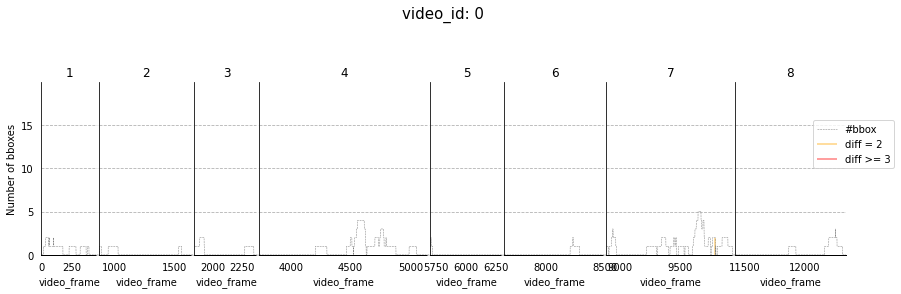

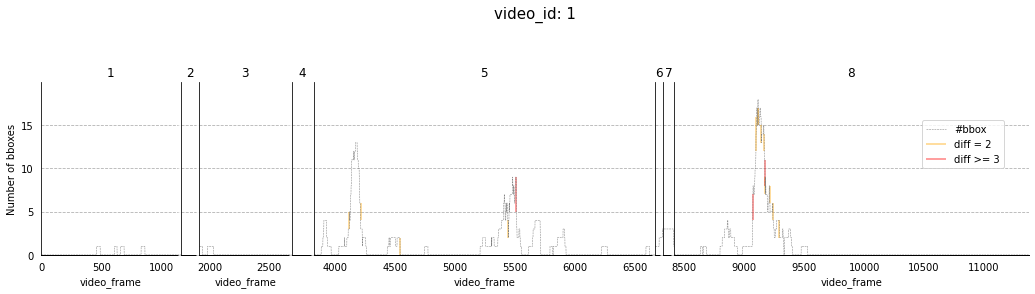

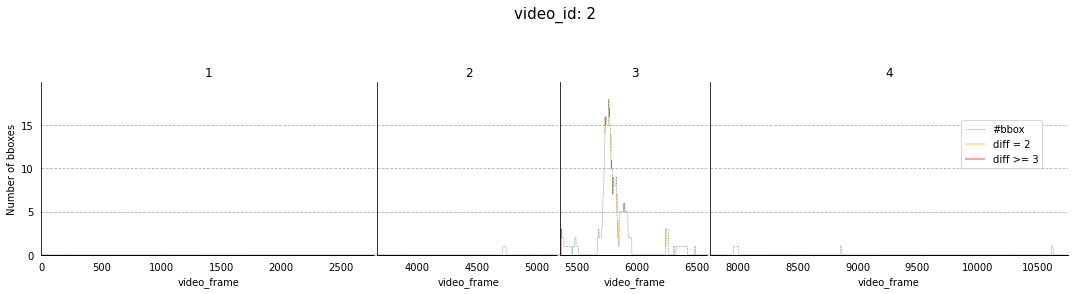

In [19]:
for i in range(3):
    plot_num_bboxes_and_diff(df=df, video_id=i)

## Images Visualization

비디오 ID별로 샘플(씬)이미지를 살펴보면 다음과 같다.<br>
엇보기에는 다들 비슷해보이는..?

In [20]:
def visualize_sample_id(ids):
    
    imgs = os.listdir(f'./data/train_images/video_{str(ids)}')
    sample_imgs = random.sample(imgs,9)
    
    fig = plt.figure(figsize=(20, 20))
    rows = 3
    cols = 3
    i = 1
    plt.title(f'Video ID : {ids}')
    for filename in sample_imgs:
        try:
            plt.rcParams["font.family"] = 'NanumGothicCoding'
            img = cv2.imread(f'./data/train_images/video_{str(ids)}/{filename}')
            ax = fig.add_subplot(rows, cols, i)
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            ax.set_xlabel(f" {filename}")
            ax.set_xticks([]), ax.set_yticks([])
            i += 1
        except:
            break

In [ ]:
visualize_sample_id(0)

In [ ]:
visualize_sample_id(1)

In [ ]:
visualize_sample_id(2)

In [21]:
def get_bboxes(annotations):
    """
    annotations: list of annotations
    return: bboxes as [x_min, y_min, x_max, y_max]
    """
    if len(annotations)==0:
        return []
    boxes = pd.DataFrame(annotations, columns=['x', 'y', 'width', 'height']).astype(np.int32).values
    # [x_min, y_min, w, h] -> [x_min, y_min, x_max, y_max]
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    return boxes   

def plot_img_and_bbox(img_path, anntations):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(16,10))
    if len(annotations)>0:
        bboxes = get_bboxes(annotations)
        for i, box in enumerate(bboxes):
            # pur bbox on image
            cv2.rectangle(img,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          color = (255, 0, 0),
                          thickness = 2)
            # numbering
            ax.text(box[0], box[1]-5, i+1, color='red')

    ax.set_axis_off()
    ax.imshow(img)


def zoom_bbox(img_path, annotations):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxes = get_bboxes(annotations)
    
    col = 7 if len(bboxes)>=7 else len(bboxes)
    row = np.ceil(len(bboxes)/7).astype(int) if len(bboxes)>7 else 1
    fig, ax = plt.subplots(row, col, figsize=(col*2, row*3))
    cnt = 0
    for i in range(row):
        
        for j in range(col):
                        
            bbox = bboxes[cnt]
            sliced_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            
            if row==1:
                ax[j].imshow(sliced_img)
                ax[j].set_title(cnt+1, color='red')
                ax[j].set_axis_off()
            else:
                ax[i,j].imshow(sliced_img)
                ax[i,j].set_title(cnt+1, color='red')
                ax[i,j].set_axis_off()
                
            cnt += 1
            
            if cnt==len(bboxes):
                break
    
        if cnt==len(bboxes):
            break      
            
    plt.show() 

In [22]:
sample_idx = 12637
sample = df.iloc[sample_idx]
print(sample)

video_id                                                           1
sequence                                                       60754
video_frame                                                     9072
sequence_frame                                                   656
image_id                                                      1-9072
annotations        [{'x': 499, 'y': 567, 'width': 63, 'height': 6...
image_path                      ./data/train_images/video_1/9072.jpg
num_bboxes                                                         7
diff_num_bboxes                                                    3
num_bboxes_lag1                                                    4
Name: 12637, dtype: object


image_id: 1-9072


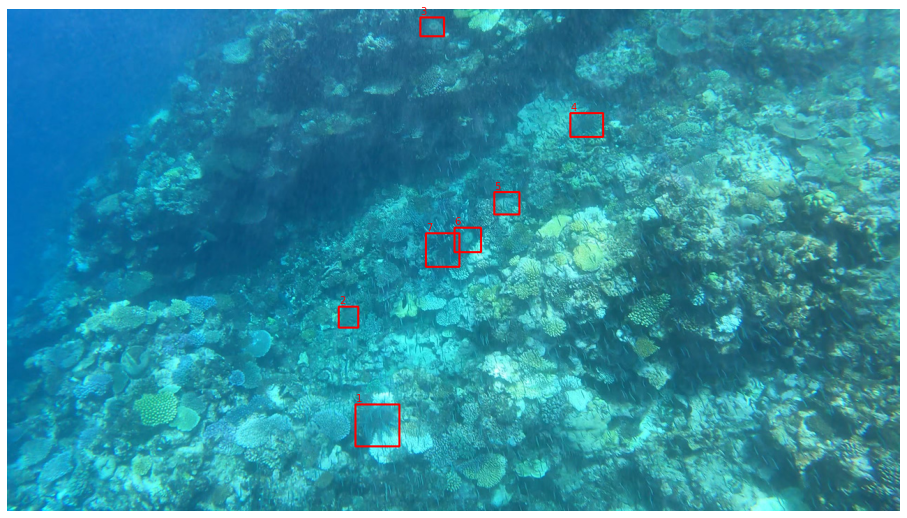

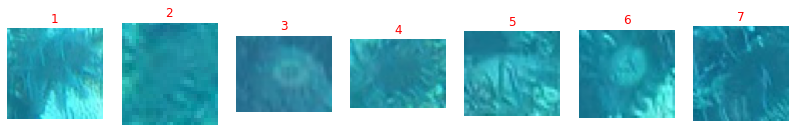

In [23]:
img_path    = sample['image_path']
annotations = sample['annotations']
print('image_id:', sample['image_id'])
# plot image with bboxes
plot_img_and_bbox(img_path, annotations)
# plot zoom of bboxes
zoom_bbox(img_path, annotations)

## Video Visualization

In [24]:
HEIGHT = 720 # image height
WIDTH  = 1280 # image width

In [40]:
def get_img_with_annotations(img_path, annotations):
    img = cv2.imread(img_path)
    video_id = img_path.split('/')[-2].split('_')[-1]
    frame_id = img_path.split('/')[-1].split('.')[0]
    img_id = video_id + '-' + frame_id
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if len(annotations)>0:
        bboxes = get_bboxes(annotations)
        for i, box in enumerate(bboxes):
            # put bbox
            cv2.rectangle(img,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          color = (0, 0, 255),
                          thickness = 2)
    # put image_id, #bbox
    cv2.putText(img,
                f'image_id: {img_id}, #bbox: {len(annotations)}',
                org = (30, 50), 
                color = (0, 0, 255), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1.0,
                thickness=3)
    
    return img

def make_video(df, video_id, start_frame, end_frame, fps=15, width=WIDTH, height=HEIGHT):
    '''
    df          : DataFrame
    video_id    : 0, 1, or 2
    start_frame : video_frame at start of video
    num_frame   : video_frame at end of video
    return      : path to video
    '''
    video_path = f'video_{video_id}_{start_frame}_to_{end_frame}.mp4' # video after encode
    tmp_path = 'tmp_' + video_path # video before encode (removed after encode)
    video = cv2.VideoWriter(tmp_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    df = df[df['video_id']==video_id].reset_index(drop=True)
    start_idx = df[df['video_frame']==start_frame].index[0]
    end_idx   = df[df['video_frame']==end_frame].index[0]
    df = df.iloc[start_idx:end_idx]
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        image_path  = row['image_path']
        annotations = row['annotations']
        frame = get_img_with_annotations(image_path, annotations)
        video.write(frame)
    
    video.release()
    
    if os.path.exists(video_path):
        os.remove(video_path)
    
    # encode by ffmpeg command 
    print(video_path)
    print(tmp_path)
#     subprocess.run(
#         ['./', 
#          '-i', tmp_path, 
#          '-loglevel', 'quiet', 
#          '-crf', '18', 
#          '-preset', 'veryfast', 
#          '-vcodec', 'libx264', 
#          video_path]
#     )
#     os.remove(tmp_path)
    
    return video_path, tmp_path

In [41]:
video_id    = sample['video_id']
start_frame = sample['video_frame'] - 100 # peek before 100 frames
end_frame   = sample['video_frame'] + 100 # peek after 100 frames
print(f'video_id: {video_id}, video_frame: {start_frame} to {end_frame}')
print('Create video ...')
video_path, tmp_path = make_video(df,
                        video_id=video_id,
                        start_frame=start_frame,
                        end_frame=end_frame)

  3%|▎         | 6/200 [00:00<00:03, 50.33it/s]

video_id: 1, video_frame: 8972 to 9172
Create video ...


100%|██████████| 200/200 [00:04<00:00, 49.60it/s]

video_1_8972_to_9172.mp4
tmp_video_1_8972_to_9172.mp4


### reference
<br>
https://www.kaggle.com/yoshikuwano/eda-non-annotated-starfish/notebook
<br>
https://www.kaggle.com/soumya9977/learning-to-sea-underwater-img-enhancement-eda/notebook
<br>
https://www.kaggle.com/diegoalejogm/great-barrier-reefs-eda-with-animations